In [20]:
%pip install kneed tslearn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 7.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
import numpy as np
import pandas as pd
import yahoo_finance_helper as yf
import time
from kneed import KneeLocator
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt


In [2]:
tickers = 'TSLA,NVDA'.split(',')
dfs = []
for ticker in tickers:
    df = yf.GetTicker(ticker)
    df['range'] = df['High']/df['Low']-1
    df['open_to_close'] = df['Close']/df['Open']-1
    df['ticker'] = ticker
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

In [3]:
feat_length = 50
feat_cols = ['Close','range','open_to_close']

def time_series(df, col, name):
    '''
    Form the lagged columns for this feature
    '''
    return df.assign(**{
        f'{name}_t-{lag}': col.shift(lag)
        for lag in range(0, feat_length)
    })

feat_dfs = []

for ticker in tickers:
    df_ticker = df[df['ticker'] == ticker].copy()
    for col in feat_cols:
        df_ticker = time_series(df_ticker, df_ticker[col], f'feat_{col}')
    
    # If any infinite value slip in, replace them with nan and drop all nan rows
    df_ticker = df_ticker.replace({-np.inf: np.nan, np.inf: np.nan})
    df_ticker = df_ticker.dropna().reset_index(drop=True)

    # Since a joining days will have similar patterns, keep only every 5th case
    df_ticker = df_ticker[::5]
    feat_dfs.append(df_ticker)

feat_df = pd.concat(feat_dfs)

print('Number of samples in the dataset:', feat_df.shape[0])
feat_df.head()


Number of samples in the dataset: 4056


,Datetime,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,range,...,feat_open_to_close_t-40,feat_open_to_close_t-41,feat_open_to_close_t-42,feat_open_to_close_t-43,feat_open_to_close_t-44,feat_open_to_close_t-45,feat_open_to_close_t-46,feat_open_to_close_t-47,feat_open_to_close_t-48,feat_open_to_close_t-49
0,2021-02-01 09:30:00-05:00,270.673340,274.899963,265.333344,271.166840,271.166840,7885834,0.0,0.0,0.036055,...,0.005972,-0.001417,-0.001708,-0.002850,0.001338,-0.001351,0.003648,-0.008396,0.006750,-0.010677
5,2021-02-01 14:30:00-05:00,277.586670,279.000000,276.766663,278.236633,278.236633,1734103,0.0,0.0,0.008069,...,0.035678,0.002131,0.006183,0.002089,0.001063,0.005972,-0.001417,-0.001708,-0.002850,0.001338
10,2021-02-02 12:30:00-05:00,292.389984,293.500000,291.433319,292.326660,292.326660,2200702,0.0,0.0,0.007091,...,-0.002984,0.003085,0.006961,-0.002208,-0.024524,0.035678,0.002131,0.006183,0.002089,0.001063
15,2021-02-03 10:30:00-05:00,284.523346,286.993317,284.354858,285.153290,285.153290,3122005,0.0,0.0,0.009279,...,0.002450,0.003174,0.003897,-0.007833,0.013975,-0.002984,0.003085,0.006961,-0.002208,-0.024524
20,2021-02-03 15:30:00-05:00,285.156647,286.160004,284.800018,284.899994,284.899994,1306503,0.0,0.0,0.004775,...,-0.002253,0.020543,-0.001757,-0.004362,-0.002815,0.002450,0.003174,0.003897,-0.007833,0.013975


In [5]:
def reshape_feats_for_clustering(feat_arr_2d, feat_length):
    feat_arrs = []

    for n in range(0, feat_arr_2d.shape[1]//feat_length):
        feat_arrs.append(np.fliplr(feat_arr_2d[:, n*feat_length:(n+1)*feat_length]))
    
    feats_3d = np.dstack(feat_arrs)
    return feats_3d

feat_cols = [col for col in feat_df.columns if 'feat' in col]
train_until = '2023-12-01'

df_train = feat_df[feat_df['Datetime'] < train_until].reset_index(drop=True)

x_train = reshape_feats_for_clustering(df_train[feat_cols].values, feat_length)

df_test = feat_df[feat_df['Datetime'] >= train_until].reset_index(drop=True)

x_test = reshape_feats_for_clustering(df_test[feat_cols].values, feat_length)

print('Shape of x_train:', x_train.shape)
print('Shape of x_test:', x_test.shape)

Shape of x_train: (4009, 50, 3)
Shape of x_test: (47, 50, 3)


In [13]:
print(x_train[2000][0])

[2.43925003e+02 8.13434539e-03 6.62345526e-03]


In [14]:
def standard_scale(x):
    mean = x.mean(axis=1, keepdims=1)
    std = x.std(axis=1,keepdims=1)
    x = (x-mean)/std

    # Replace infinite with a large finite value
    x[x == np.inf] = 1e9
    x[x == -np.inf] = -1e9

    return x

# Scale only the close time series, which is the first feature in the 3D array
x_train_scaled = x_train.copy()
x_train_scaled [:,:,0] = standard_scale(x_train[:,:,0])

x_test_scaled = x_test.copy()
x_test_scaled [:,:,0] = standard_scale(x_test[:,:,0])

Clustering with K = 2
Inertia: 30.32363754118189
Time taken: 1.061262845993042

Clustering with K = 3
Inertia: 26.83218772533104
Time taken: 3.225160837173462

Clustering with K = 4
Inertia: 23.904152964373825
Time taken: 3.733470916748047

Clustering with K = 5
Inertia: 22.321002037502204
Time taken: 2.8401858806610107

Clustering with K = 6
Inertia: 21.079807357095248
Time taken: 5.194517135620117

Clustering with K = 7
Inertia: 20.19783606144057
Time taken: 5.097845077514648

Clustering with K = 8
Inertia: 19.538218870176575
Time taken: 5.807665824890137

Clustering with K = 9
Inertia: 18.988097448335605
Time taken: 5.765015125274658

Clustering with K = 10
Inertia: 18.349014431881255
Time taken: 5.905503988265991

Clustering with K = 11
Inertia: 17.958184342629853
Time taken: 4.3538429737091064

Clustering with K = 12
Inertia: 17.5503326036667
Time taken: 5.42475962638855

Clustering with K = 13
Inertia: 17.25831333249252
Time taken: 4.818368673324585

Clustering with K = 14
Inerti

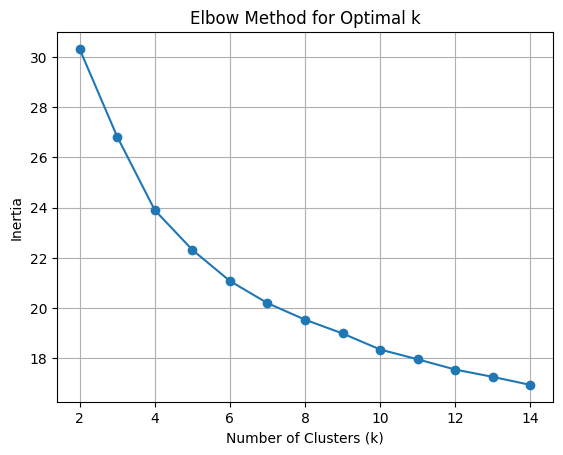

In [23]:
distance = []
clusterings = []

t0 = time.time()
k_range = range(2,15)

for k in k_range:
    cluster_t0 = time.time()
    print('Clustering with K =', k)
    kmeans = TimeSeriesKMeans(
        n_clusters=k,
        metric='euclidean',
        random_state=42,
        n_jobs=-1
    )

    kmeans.fit(x_train_scaled)
    clusterings.append(kmeans)
    distance.append(kmeans.inertia_)

    print('Inertia:', kmeans.inertia_)
    print('Time taken:', time.time() - cluster_t0)
    print('')

print('Overall fitting time:', time.time() - t0)

elbow_locator = KneeLocator(k_range, distance, curve='convex',direction='decreasing')
optimal_k = elbow_locator.elbow

print(f'\nOptimal k: {optimal_k}')

plt.plot(k_range,  distance, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [24]:
optimal_kmeans = clusterings[optimal_k-2]
df_train['cluster'] = optimal_kmeans.predict(x_train_scaled)
df_test['cluster'] = optimal_kmeans.predict(x_test_scaled)

# Cluster counts
print(df_train['cluster'].value_counts)
print(df_test['cluster'].value_counts)

<bound method IndexOpsMixin.value_counts of 0       4
1       5
2       5
3       1
4       1
       ..
4004    4
4005    5
4006    5
4007    5
4008    1
Name: cluster, Length: 4009, dtype: int64>
<bound method IndexOpsMixin.value_counts of 0     3
1     0
2     0
3     0
4     5
5     1
6     1
7     2
8     3
9     0
10    4
11    4
12    3
13    4
14    0
15    0
16    5
17    1
18    1
19    2
20    2
21    3
22    0
23    4
24    1
25    1
26    5
27    5
28    5
29    1
30    1
31    1
32    2
33    2
34    3
35    1
36    5
37    5
38    5
39    1
40    1
41    1
42    2
43    2
44    3
45    3
46    3
Name: cluster, dtype: int64>


In [25]:
granular_kmeans = TimeSeriesKMeans(
    n_clusters=50,
    metric='euclidean',
    random_state=42,
    n_jobs=-1
)

granular_kmeans.fit(x_train_scaled)
df_train['cluster_granular'] = granular_kmeans.predict(x_train_scaled)
df_test['cluster_granular'] = granular_kmeans.predict(x_test_scaled)

df_train['cluster_granular'].value_counts().sort_values(ascending=False).head()

cluster_granular
10    178
12    168
1     164
38    151
32    146
Name: count, dtype: int64